In [27]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LightGBMModel
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor

In [28]:
# Load ais_train.csv with separator '|'
train_df = pd.read_csv("../project/ais_train.csv", sep="|")
train_df["time"] = pd.to_datetime(train_df["time"])

In [29]:
# Load ais_test.csv with separator ','
test_df = pd.read_csv("../project/ais_test.csv", sep=",")
test_df["time"] = pd.to_datetime(test_df["time"])

In [30]:
# Use 'vesselId' instead of 'vessel_id'
# Select only vessel IDs that are in both train and test datasets
common_vessel_ids = set(train_df["vesselId"]).intersection(set(test_df["vesselId"]))
train_df = train_df[train_df["vesselId"].isin(common_vessel_ids)]

In [31]:
# Group the training data by vesselId
groups = train_df.groupby("vesselId")

In [32]:
# Initialize dictionaries to store TimeSeries objects, last training times, and feature importances
timeseries_dict = {}
last_train_time = {}
feature_importances = {}

In [33]:
# Process each vesselId group
for vessel_id, group_df in groups:
    # Sort on time
    group_df = group_df.sort_values("time")
    # Set index to time
    group_df = group_df.set_index("time")
    # Select features (latitude and longitude)
    features_df = group_df[["latitude", "longitude"]]
    # Resample data to hourly frequency with mean and linear interpolation
    features_df = features_df.resample("h").mean().interpolate(method="cubic")
    # Create Darts TimeSeries object
    ts = TimeSeries.from_dataframe(features_df, value_cols=["latitude", "longitude"])
    # Store the TimeSeries object and last training time
    timeseries_dict[vessel_id] = ts
    last_train_time[vessel_id] = features_df.index.max()

In [34]:
# Initialize a dictionary to store predictions
predictions = {}

In [35]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LightGBMModel
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor  # Ensure this is imported

# Initialize dictionaries to store predictions and feature importances
predictions = {}
feature_importances = {}

# Fit LightGBM models, predict, and compute feature importance for each TimeSeries object
for vessel_id, ts in timeseries_dict.items():
    # Get the last training time
    last_time = last_train_time[vessel_id]
    
    # Get test times for this vessel
    vessel_test_df = test_df[test_df["vesselId"] == vessel_id]
    test_times = vessel_test_df["time"]
    
    # Compute the time differences in hours
    time_diffs = (test_times - last_time).dt.total_seconds() / 3600
    
    # Get the maximum forecast horizon needed
    max_n = int(np.ceil(time_diffs.max()))
    if max_n <= 0:
        continue  # Skip if no future times to predict
    
    # Initialize LightGBM model with lag parameters
    model = LightGBMModel(
        lags=48,  # the correct value is between 48 and 96
        learning_rate=0.1,
    )
    
    # Fit the model
    model.fit(ts)
    
    # Predict up to the maximum horizon needed
    forecast = model.predict(max_n)
    
    # Store the forecast and last time
    predictions[vessel_id] = (forecast, last_time)
    
    # Extract feature importance from the underlying LightGBM models
    # Check if the model uses MultiOutputRegressor
    if isinstance(model.model, MultiOutputRegressor):
        estimators = model.model.estimators_
        # Assuming all estimators have the same feature names
        feature_names = estimators[0].feature_name_
        # Initialize a list to store feature importances from each estimator
        importances = []
        for est in estimators:
            importances.append(est.feature_importances_)
        # Convert list to numpy array for aggregation
        importances = np.array(importances)
        # Compute the mean feature importance across all estimators
        mean_importance = np.mean(importances, axis=0)
        # Create a dictionary mapping feature names to their mean importance
        feature_importance_dict = dict(zip(feature_names, mean_importance))
        feature_importances[vessel_id] = feature_importance_dict
    else:
        # If not using MultiOutputRegressor, directly access feature importance
        feature_names = model.model.feature_name_
        importance = model.model.feature_importances_
        feature_importance_dict = dict(zip(feature_names, importance))
        feature_importances[vessel_id] = feature_importance_dict


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score 44.152453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score -4.685515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 2987, number of used features: 96
[LightGBM] [Info] Start t


Aggregated Top 10 Feature Importance Statistics:
                 Mean  Median    Std Dev
Column_94  423.895349   433.5  45.674611
Column_95  419.123256   437.0  65.776401
Column_92   92.034884    88.5  29.974287
Column_0    91.279070    88.5  46.450066
Column_93   90.874419    85.5  31.674831
Column_1    67.995349    65.0  32.665144
Column_90   57.379070    53.0  22.188535
Column_91   56.713953    51.0  24.826563
Column_89   46.246512    40.0  24.291737
Column_88   44.962791    40.5  21.396098


/var/folders/5q/k66vnm0d2ps_3_nhtc3cx0qr0000gn/T/ipykernel_1980/3879531189.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance_stats['Mean'], y=top_importance_stats.index, palette='viridis')


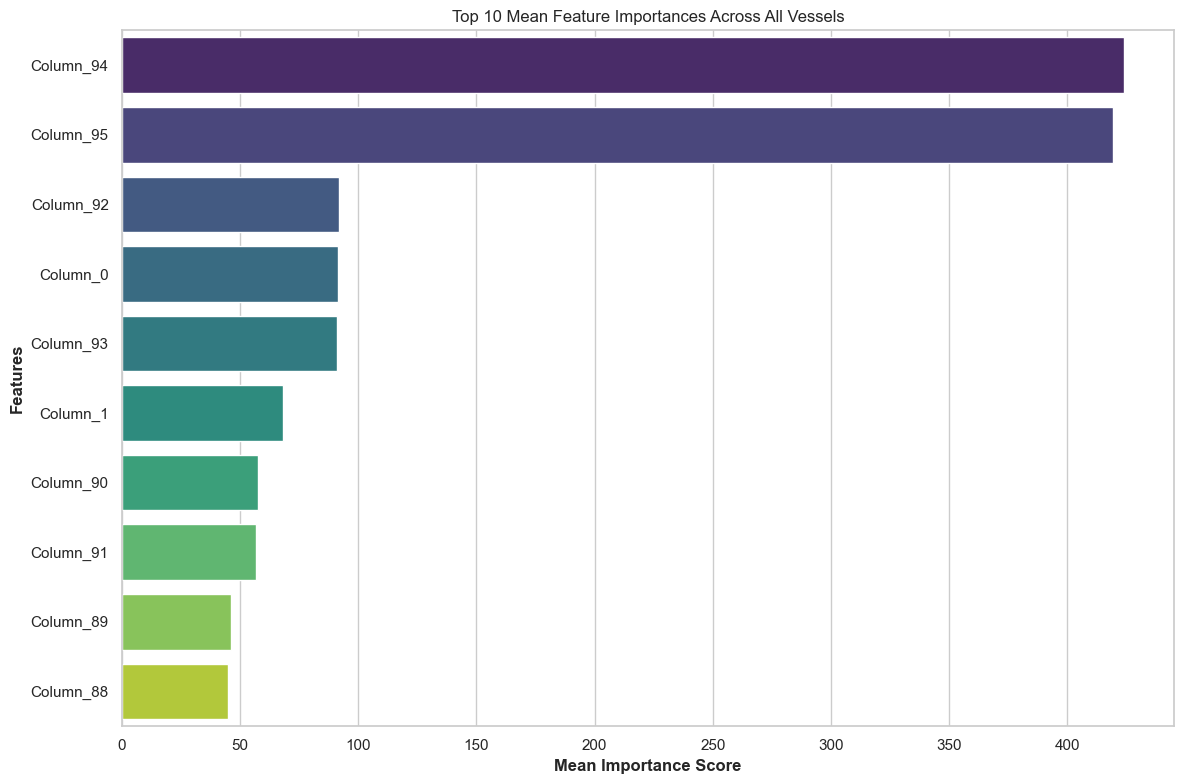

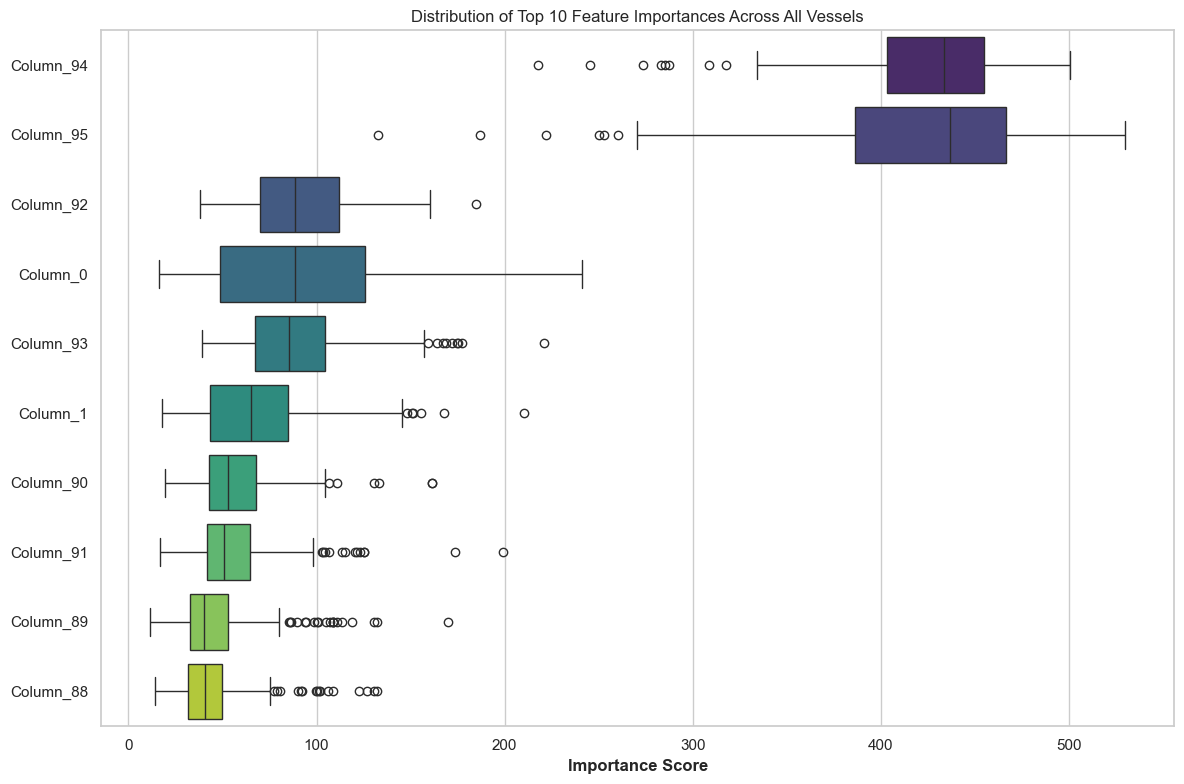

In [40]:
# Convert feature_importances to DataFrame for aggregation
feature_importance_df = pd.DataFrame.from_dict(feature_importances, orient='index')

# Fill missing values if any
feature_importance_df.fillna(0, inplace=True)

# Compute summary statistics
mean_importance = feature_importance_df.mean().sort_values(ascending=False)
median_importance = feature_importance_df.median().sort_values(ascending=False)
std_importance = feature_importance_df.std().sort_values(ascending=False)

# Combine statistics into a single DataFrame
importance_stats = pd.DataFrame({
    'Mean': mean_importance,
    'Median': median_importance,
    'Std Dev': std_importance
})

# Sort by mean importance
importance_stats = importance_stats.sort_values(by='Mean', ascending=False)

# Select the top 10 features based on mean importance
top_10_features = importance_stats.head(10).index.tolist()

# Filter the importance_stats to include only top 10 features
top_importance_stats = importance_stats.loc[top_10_features]

# Filter the feature_importance_df to include only top 10 features
top_feature_importance_df = feature_importance_df[top_10_features]

# Display aggregated feature importance statistics for top 10 features
print("\nAggregated Top 10 Feature Importance Statistics:")
print(top_importance_stats)

# Visualize mean feature importances for top 10 features
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importance_stats['Mean'], y=top_importance_stats.index, palette='viridis')
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Mean Feature Importances Across All Vessels')
plt.tight_layout()
plt.show()

# Optionally, visualize distribution with box plots for top 10 features
plt.figure(figsize=(12, 8))
sns.boxplot(data=top_feature_importance_df, orient='h', palette='viridis')
plt.xlabel('Importance Score')
plt.title('Distribution of Top 10 Feature Importances Across All Vessels')
plt.tight_layout()
plt.show()

# Export the aggregated top 10 feature importance statistics to a CSV file
top_importance_stats.to_csv('aggregated_top10_feature_importances.csv')

# Optionally, export the full top 10 feature importance DataFrame per vessel to a CSV file
top_feature_importance_df.to_csv('top10_feature_importances_per_vessel.csv')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score 44.152453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score -4.685515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 2987, number of used features: 96
[LightGBM] [Info] Start t

/var/folders/5q/k66vnm0d2ps_3_nhtc3cx0qr0000gn/T/ipykernel_1980/3330086047.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance_stats['Mean'], y=top_importance_stats.index, palette='viridis')


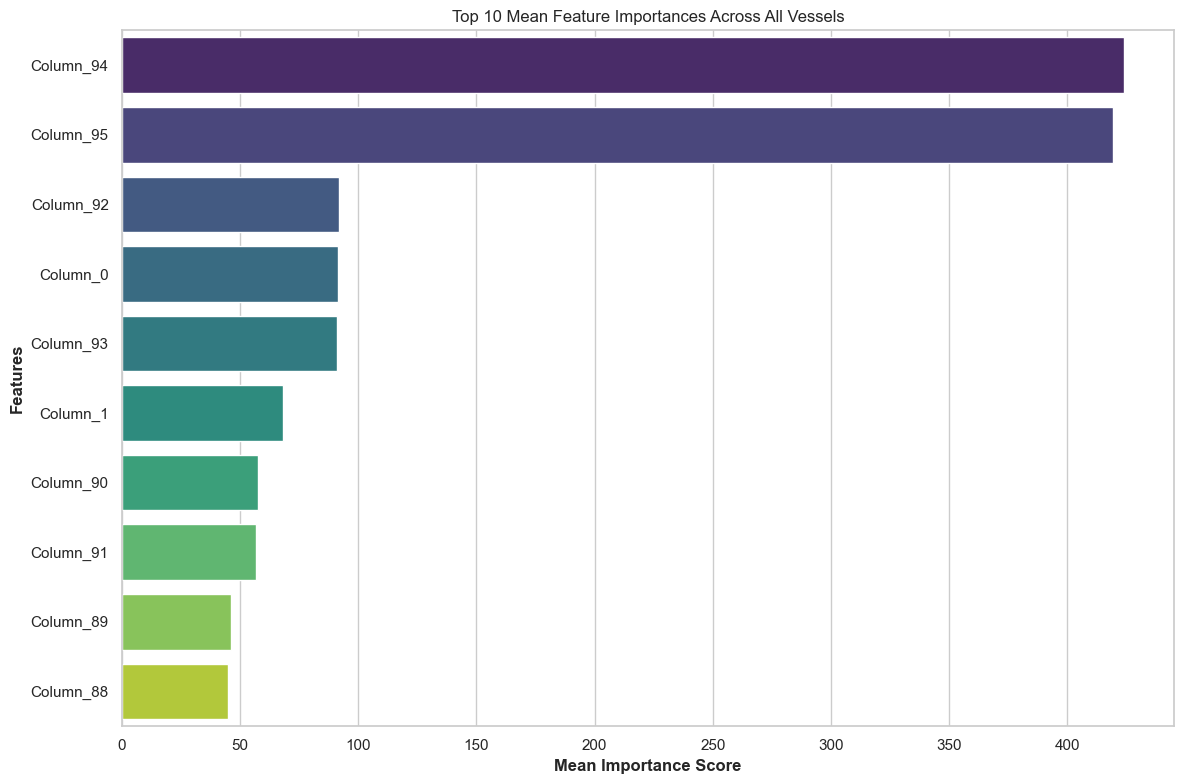

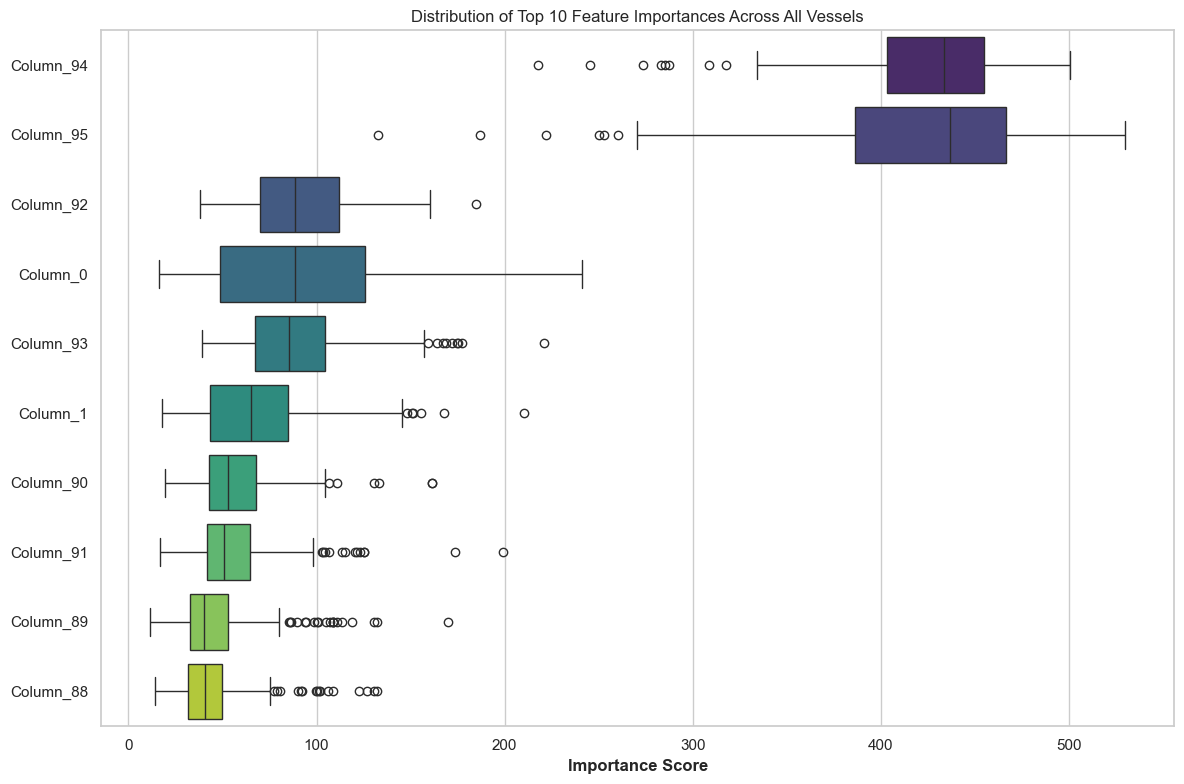


Exported top 10 feature importances to CSV files.


In [41]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LightGBMModel
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Initialize dictionaries to store predictions and feature importances
predictions = {}
feature_importances = {}

# Fit LightGBM models, predict, and compute feature importance for each TimeSeries object
for vessel_id, ts in timeseries_dict.items():
    # Get the last training time
    last_time = last_train_time[vessel_id]
    
    # Get test times for this vessel
    vessel_test_df = test_df[test_df["vesselId"] == vessel_id]
    test_times = vessel_test_df["time"]
    
    # Compute the time differences in hours
    time_diffs = (test_times - last_time).dt.total_seconds() / 3600
    
    # Get the maximum forecast horizon needed
    max_n = int(np.ceil(time_diffs.max()))
    if max_n <= 0:
        continue  # Skip if no future times to predict
    
    # Initialize LightGBM model with lag parameters
    model = LightGBMModel(
        lags=48,  # the correct value is between 48 and 96
        learning_rate=0.1,
    )
    
    # Fit the model
    model.fit(ts)
    
    # Predict up to the maximum horizon needed
    forecast = model.predict(max_n)
    
    # Store the forecast and last time
    predictions[vessel_id] = (forecast, last_time)
    
    # Extract feature importance from the underlying LightGBM models
    # Check if the model uses MultiOutputRegressor
    if isinstance(model.model, MultiOutputRegressor):
        estimators = model.model.estimators_
        # Ensure that all estimators have the same feature names
        feature_names = estimators[0].feature_name_
        for est in estimators:
            assert est.feature_name_ == feature_names, f"Feature names mismatch in vessel {vessel_id}"
        # Initialize a list to store feature importances from each estimator
        importances = [est.feature_importances_ for est in estimators]
        # Convert list to numpy array for aggregation
        importances = np.array(importances)
        # Compute the mean feature importance across all estimators
        mean_importance = np.mean(importances, axis=0)
        # Create a dictionary mapping feature names to their mean importance
        feature_importance_dict = dict(zip(feature_names, mean_importance))
        feature_importances[vessel_id] = feature_importance_dict
    else:
        # If not using MultiOutputRegressor, directly access feature importance
        feature_names = model.model.feature_name_
        importance = model.model.feature_importances_
        feature_importance_dict = dict(zip(feature_names, importance))
        feature_importances[vessel_id] = feature_importance_dict

# Convert feature_importances to DataFrame for aggregation
feature_importance_df = pd.DataFrame.from_dict(feature_importances, orient='index')

# Fill missing values if any
feature_importance_df.fillna(0, inplace=True)

# Verify that feature names are correctly set
print("\nFeature Importance DataFrame Columns:")
print(feature_importance_df.columns.tolist())

print("\nFeature Importance DataFrame Sample:")
print(feature_importance_df.head())

# Compute summary statistics
mean_importance = feature_importance_df.mean().sort_values(ascending=False)
median_importance = feature_importance_df.median().sort_values(ascending=False)
std_importance = feature_importance_df.std().sort_values(ascending=False)

# Combine statistics into a single DataFrame
importance_stats = pd.DataFrame({
    'Mean': mean_importance,
    'Median': median_importance,
    'Std Dev': std_importance
})

# Sort by mean importance
importance_stats = importance_stats.sort_values(by='Mean', ascending=False)

# Select the top 10 features based on mean importance
TOP_N = 10
top_n_features = importance_stats.head(TOP_N).index.tolist()

# Filter the importance_stats to include only top N features
top_importance_stats = importance_stats.loc[top_n_features]

# Filter the feature_importance_df to include only top N features
top_feature_importance_df = feature_importance_df[top_n_features]

# Display aggregated feature importance statistics for top N features
print(f"\nAggregated Top {TOP_N} Feature Importance Statistics:")
print(top_importance_stats)

# Visualize mean feature importances for top N features
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x=top_importance_stats['Mean'], y=top_importance_stats.index, palette='viridis')
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.title(f'Top {TOP_N} Mean Feature Importances Across All Vessels')
plt.tight_layout()
plt.show()

# Optionally, visualize distribution with box plots for top N features
plt.figure(figsize=(12, 8))
sns.boxplot(data=top_feature_importance_df, orient='h', palette='viridis')
plt.xlabel('Importance Score')
plt.title(f'Distribution of Top {TOP_N} Feature Importances Across All Vessels')
plt.tight_layout()
plt.show()

# Export the aggregated top N feature importance statistics to a CSV file
top_importance_stats.to_csv(f'aggregated_top{TOP_N}_feature_importances.csv')

# Export the full top N feature importance DataFrame per vessel to a CSV file
top_feature_importance_df.to_csv(f'top{TOP_N}_feature_importances_per_vessel.csv')

print(f"\nExported top {TOP_N} feature importances to CSV files.")


In [46]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LightGBMModel
import lightgbm as lgb
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load ais_train.csv with separator '|'
train_df = pd.read_csv('../project/ais_train.csv', sep='|')
train_df['time'] = pd.to_datetime(train_df['time'])

# Load ais_test.csv with separator ','
test_df = pd.read_csv('../project/ais_test.csv', sep=',')
test_df['time'] = pd.to_datetime(test_df['time'])

# Use 'vesselId' instead of 'vessel_id'
# Select only vessel IDs that are in both train and test datasets
common_vessel_ids = set(train_df['vesselId']).intersection(set(test_df['vesselId']))
train_df = train_df[train_df['vesselId'].isin(common_vessel_ids)]

# Group the training data by vesselId
groups = train_df.groupby('vesselId')

# Initialize dictionaries to store TimeSeries objects and last training times
timeseries_dict = {}
last_train_time = {}

# Process each vesselId group
for vessel_id, group_df in groups:
    # Sort on time
    group_df = group_df.sort_values('time')
    # Set index to time
    group_df = group_df.set_index('time')
    # Select features (latitude and longitude)
    features_df = group_df[['latitude', 'longitude']]
    # Resample data to hourly frequency with mean and linear interpolation
    features_df = features_df.resample('h').mean().interpolate(method='cubic')
    # Create Darts TimeSeries object
    ts = TimeSeries.from_dataframe(features_df, value_cols=['latitude', 'longitude'])
    # Store the TimeSeries object and last training time
    timeseries_dict[vessel_id] = ts
    last_train_time[vessel_id] = features_df.index.max()

# Initialize a dictionary to store predictions
predictions = {}

# Initialize a dictionary to accumulate feature importances
feature_importances_accum = defaultdict(float)
feature_counts = defaultdict(int)

# Fit LightGBM models and predict for each TimeSeries object
for vessel_id, ts in timeseries_dict.items():
    # Get the last training time
    last_time = last_train_time[vessel_id]
    # Get test times for this vessel
    vessel_test_df = test_df[test_df['vesselId'] == vessel_id]
    test_times = vessel_test_df['time']
    if test_times.empty:
        print(f"No test times for vessel {vessel_id}. Skipping.")
        continue
    # Compute the time differences in hours
    time_diffs = (test_times - last_time).dt.total_seconds() / 3600
    # Get the maximum forecast horizon needed
    max_n = int(np.ceil(time_diffs.max()))
    if max_n <= 0:
        print(f"Max forecast horizon <= 0 for vessel {vessel_id}. Skipping.")
        continue  # Skip if no future times to predict
    # Initialize LightGBM model with lag parameters
    model = LightGBMModel(
        lags=48,  # the correct value is between 48 and 96
        learning_rate=0.1,
        #n_estimators=100,
        #max_depth=10,
    )
    # Fit the model
    try:
        model.fit(ts)
    except Exception as e:
        print(f"Error training model for vessel {vessel_id}: {e}")
        continue
    # Predict up to the maximum horizon needed
    try:
        forecast = model.predict(max_n)
        # Store the forecast and last time
        predictions[vessel_id] = (forecast, last_time)
    except Exception as e:
        print(f"Error predicting for vessel {vessel_id}: {e}")
        continue

    # Extract feature importance from the trained model
    try:
        # Access the underlying LightGBM model(s)
        lgb_models = model.model  # This could be a list or a single model
        if isinstance(lgb_models, list):
            print(f"Vessel {vessel_id} has multiple LightGBM models (multi-output).")
            for target_model in lgb_models:
                importances = target_model.feature_importance(importance_type='gain')
                feature_names = target_model.feature_name()
                for name, imp in zip(feature_names, importances):
                    feature_importances_accum[name] += imp
                    feature_counts[name] += 1
        else:
            print(f"Vessel {vessel_id} has a single LightGBM model.")
            importances = lgb_models.feature_importance(importance_type='gain')
            feature_names = lgb_models.feature_name()
            for name, imp in zip(feature_names, importances):
                feature_importances_accum[name] += imp
                feature_counts[name] += 1
    except AttributeError as e:
        print(f"AttributeError for vessel {vessel_id}: {e}")
    except Exception as e:
        print(f"Unexpected error extracting feature importance for vessel {vessel_id}: {e}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score 44.152453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score -4.685515
Vessel 61e9f38eb937134a3c4bfd8d has a single LightGBM model.
AttributeError for vessel 61e9f38eb937134a3c4bfd8d: 'MultiOutputRegressor' object has no attribute 'feature_importance'
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=t

In [49]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LightGBMModel
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load ais_train.csv with separator '|'
train_df = pd.read_csv('../project/ais_train.csv', sep='|')
train_df['time'] = pd.to_datetime(train_df['time'])

# Load ais_test.csv with separator ','
test_df = pd.read_csv('../project/ais_test.csv', sep=',')
test_df['time'] = pd.to_datetime(test_df['time'])

# Use 'vesselId' instead of 'vessel_id'
# Select only vessel IDs that are in both train and test datasets
common_vessel_ids = set(train_df['vesselId']).intersection(set(test_df['vesselId']))
train_df = train_df[train_df['vesselId'].isin(common_vessel_ids)]

# Group the training data by vesselId
groups = train_df.groupby('vesselId')

# Initialize dictionaries to store TimeSeries objects and last training times
timeseries_dict = {}
last_train_time = {}

# Process each vesselId group
for vessel_id, group_df in groups:
    # Sort on time
    group_df = group_df.sort_values('time')
    # Set index to time
    group_df = group_df.set_index('time')
    # Select features (latitude and longitude)
    features_df = group_df[['latitude', 'longitude']]
    # Resample data to hourly frequency with mean and linear interpolation
    features_df = features_df.resample('h').mean().interpolate(method='cubic')
    # Create Darts TimeSeries object
    ts = TimeSeries.from_dataframe(features_df, value_cols=['latitude', 'longitude'])
    # Store the TimeSeries object and last training time
    timeseries_dict[vessel_id] = ts
    last_train_time[vessel_id] = features_df.index.max()

# Initialize a dictionary to store predictions
predictions = {}

# Initialize dictionaries to accumulate feature importances
feature_importances_accum = defaultdict(float)
feature_counts = defaultdict(int)

# Counters for progress tracking
total_vessels = len(timeseries_dict)
processed_vessels = 0
error_vessels = 0

# Fit LightGBM models and predict for each TimeSeries object
for vessel_id, ts in timeseries_dict.items():
    processed_vessels += 1
    print(f"Processing vessel ID: {vessel_id} ({processed_vessels}/{total_vessels})")
    
    # Get the last training time
    last_time = last_train_time[vessel_id]
    
    # Get test times for this vessel
    vessel_test_df = test_df[test_df['vesselId'] == vessel_id]
    test_times = vessel_test_df['time']
    
    if test_times.empty:
        print(f"  No test times for vessel {vessel_id}. Skipping.")
        continue
    
    # Compute the time differences in hours
    time_diffs = (test_times - last_time).dt.total_seconds() / 3600
    
    # Get the maximum forecast horizon needed
    max_n = int(np.ceil(time_diffs.max()))
    if max_n <= 0:
        print(f"  Max forecast horizon <= 0 for vessel {vessel_id}. Skipping.")
        continue  # Skip if no future times to predict
    
    # Initialize LightGBM model with lag parameters
    model = LightGBMModel(
        lags=48,  # Adjust as needed between 48 and 96
        learning_rate=0.1,
    )
    
    # Fit the model
    try:
        model.fit(ts)
        print("  Model training successful.")
    except Exception as e:
        print(f"  Error training model for vessel {vessel_id}: {e}")
        error_vessels += 1
        continue
    
    # Predict up to the maximum horizon needed
    try:
        forecast = model.predict(max_n)
        # Store the forecast and last time
        predictions[vessel_id] = (forecast, last_time)
        print("  Prediction successful.")
    except Exception as e:
        print(f"  Error predicting for vessel {vessel_id}: {e}")
        error_vessels += 1
        continue

    # Extract feature importance from the trained model
    try:
        lgb_models = model.model
        # Check if it's a list (multi-output) or single model
        if isinstance(lgb_models, list):
            print(f"  The model has {len(lgb_models)} underlying LightGBM models.")
            # Iterate through each model corresponding to a target
            for target_idx, target_model in enumerate(lgb_models):
                print(f"    Extracting feature importances for target {target_idx}.")
                importances = target_model.feature_importance(importance_type='gain')
                feature_names = target_model.feature_name()
                
                if len(importances) != len(feature_names):
                    print(f"    Mismatch in importances and feature names for target {target_idx}. Skipping.")
                    continue
                
                # Accumulate importances
                for name, imp in zip(feature_names, importances):
                    feature_importances_accum[name] += imp
                    feature_counts[name] += 1
        else:
            print("  Single LightGBM model detected.")
            importances = lgb_models.feature_importance(importance_type='gain')
            feature_names = lgb_models.feature_name()
            
            if len(importances) != len(feature_names):
                print("    Mismatch in importances and feature names. Skipping.")
            else:
                # Accumulate importances
                for name, imp in zip(feature_names, importances):
                    feature_importances_accum[name] += imp
                    feature_counts[name] += 1
        print("  Feature importances extracted.")
    except AttributeError as e:
        print(f"  AttributeError when extracting feature importances for vessel {vessel_id}: {e}")
        error_vessels += 1
    except Exception as e:
        print(f"  Unexpected error when extracting feature importances for vessel {vessel_id}: {e}")
        error_vessels += 1

print(f"\nTotal vessels processed: {processed_vessels}")
print(f"Total vessels with errors: {error_vessels}")

# Check if any feature importances were accumulated
if not feature_importances_accum:
    print("No feature importances were accumulated. Please check the feature importance extraction process.")
else:
    # Calculate average feature importances
    average_feature_importances = {}
    for feature, total_imp in feature_importances_accum.items():
        average_feature_importances[feature] = total_imp / feature_counts[feature]

    # Convert to DataFrame for easier plotting
    feature_importances_df = pd.DataFrame({
        'feature': list(average_feature_importances.keys()),
        'importance': list(average_feature_importances.values())
    })

    # Sort features by importance
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    # Debug: Print the feature importances
    print("\nAverage Feature Importances:")
    print(feature_importances_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
    plt.xlabel('Average Feature Importance (Gain)')
    plt.title('Feature Importance Across All Vessels')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# Initialize a list to store submission rows
submission_rows = []

# Generate predictions for the submission file
for idx, row in test_df.iterrows():
    vessel_id = row['vesselId']
    test_time = row['time']
    test_id = row['ID']  # Assuming 'ID' column exists in test_df
    # Check if predictions are available for this vessel_id
    if vessel_id in predictions:
        forecast_ts, last_time = predictions[vessel_id]
        time_diff = (test_time - last_time).total_seconds() / 3600
        index = int(np.round(time_diff)) - 1  # Adjust index since forecast starts from last_time + 1 hour
        # Convert forecast_ts to DataFrame
        forecast_df = forecast_ts.pd_dataframe()
        # Check if index is within forecast horizon
        if 0 <= index < len(forecast_df):
            predicted_lat = forecast_df['latitude'].iloc[index]
            predicted_lon = forecast_df['longitude'].iloc[index]
        else:
            predicted_lat = np.nan
            predicted_lon = np.nan
    else:
        predicted_lat = np.nan
        predicted_lon = np.nan
    # Append the prediction to the submission list
    submission_rows.append({
        'ID': test_id,
        'longitude_predicted': predicted_lon,
        'latitude_predicted': predicted_lat
    })

# Create a submission DataFrame from the list
submission_df = pd.DataFrame(submission_rows)

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file created:")
print(submission_df)


Processing vessel ID: 61e9f38eb937134a3c4bfd8d (1/215)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score 44.152453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24480
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 96
[LightGBM] [Info] Start training from score -4.685515
  Model training successful.
  Prediction successful.
  Single LightGBM model detected.
  AttributeError when extracting feature importances for vessel 61e9f38eb937134a3c4bfd8d: 'MultiOutputRegressor' object has no attribute 'feature_importance'
Processing ve

In [54]:
# Cell 1: Import Libraries and Configure Settings

import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import LightGBMModel
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, info_plots

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")



In [56]:
# Cell 2: Load and Preprocess Data

def load_and_preprocess_data(train_path='../project/ais_train.csv', test_path='../project/ais_test.csv'):
    """
    Load and preprocess training and testing data.
    
    Parameters:
        train_path (str): Path to the training CSV file.
        test_path (str): Path to the testing CSV file.
        
    Returns:
        train_df (pd.DataFrame): Preprocessed training DataFrame.
        test_df (pd.DataFrame): Preprocessed testing DataFrame.
        common_vessel_ids (set): Set of vessel IDs present in both train and test datasets.
    """
    # Load training data with separator '|'
    train_df = pd.read_csv(train_path, sep='|')
    train_df['time'] = pd.to_datetime(train_df['time'])
    
    # Load testing data with separator ','
    test_df = pd.read_csv(test_path, sep=',')
    test_df['time'] = pd.to_datetime(test_df['time'])
    
    # Select only vessel IDs that are in both train and test datasets
    common_vessel_ids = set(train_df['vesselId']).intersection(set(test_df['vesselId']))
    train_df = train_df[train_df['vesselId'].isin(common_vessel_ids)]
    
    print(f"Loaded {len(train_df)} training records and {len(test_df)} testing records.")
    print(f"Number of common vessels: {len(common_vessel_ids)}")
    
    return train_df, test_df, common_vessel_ids

# Execute the function
train_df, test_df, common_vessel_ids = load_and_preprocess_data()


Loaded 741728 training records and 51739 testing records.
Number of common vessels: 215


In [57]:
# Cell 3: Create TimeSeries Objects

def create_timeseries(train_df, common_vessel_ids, resample_freq='h'):
    """
    Create Darts TimeSeries objects for each vessel.
    
    Parameters:
        train_df (pd.DataFrame): Training DataFrame.
        common_vessel_ids (set): Set of common vessel IDs.
        resample_freq (str): Resampling frequency (default is hourly).
        
    Returns:
        timeseries_dict (dict): Dictionary of TimeSeries objects keyed by vesselId.
        last_train_time (dict): Dictionary of last training times keyed by vesselId.
    """
    groups = train_df.groupby('vesselId')
    timeseries_dict = {}
    last_train_time = {}
    
    for vessel_id, group_df in groups:
        # Sort by time
        group_df = group_df.sort_values('time')
        # Set index to time
        group_df = group_df.set_index('time')
        # Select features (latitude and longitude)
        features_df = group_df[['latitude', 'longitude']]
        # Resample data to specified frequency with mean and cubic interpolation
        features_df = features_df.resample(resample_freq).mean().interpolate(method='cubic')
        # Create Darts TimeSeries object
        ts = TimeSeries.from_dataframe(features_df, value_cols=['latitude', 'longitude'])
        # Store the TimeSeries object and last training time
        timeseries_dict[vessel_id] = ts
        last_train_time[vessel_id] = features_df.index.max()
    
    print(f"Created TimeSeries objects for {len(timeseries_dict)} vessels.")
    return timeseries_dict, last_train_time

# Execute the function
timeseries_dict, last_train_time = create_timeseries(train_df, common_vessel_ids)


Created TimeSeries objects for 215 vessels.


In [59]:
# Cell 4: Train LightGBM Models for Latitude and Longitude Separately

def train_models(timeseries_dict, last_train_time, lags=48, learning_rate=0.1):
    """
    Train separate LightGBM models for latitude and longitude for each vessel.
    
    Parameters:
        timeseries_dict (dict): Dictionary of TimeSeries objects.
        last_train_time (dict): Dictionary of last training times.
        lags (int): Number of lag features.
        learning_rate (float): Learning rate for LightGBM.
        
    Returns:
        models_lat (dict): Dictionary of trained LightGBM models for latitude keyed by vesselId.
        models_lon (dict): Dictionary of trained LightGBM models for longitude keyed by vesselId.
        feature_data_lat (dict): Feature DataFrames for latitude.
        feature_data_lon (dict): Feature DataFrames for longitude.
    """
    models_lat = {}
    models_lon = {}
    feature_data_lat = {}
    feature_data_lon = {}
    
    for vessel_id, ts in timeseries_dict.items():
        # Split the TimeSeries into two univariate series
        ts_lat = ts['latitude']
        ts_lon = ts['longitude']
        
        # Initialize LightGBM models
        model_lat = LightGBMModel(
            lags=lags,
            learning_rate=learning_rate,
            # You can set other parameters like n_estimators, max_depth here
        )
        model_lon = LightGBMModel(
            lags=lags,
            learning_rate=learning_rate,
            # Set other parameters if needed
        )
        
        # Fit the models
        model_lat.fit(ts_lat)
        model_lon.fit(ts_lon)
        
        # Store the trained models
        models_lat[vessel_id] = model_lat
        models_lon[vessel_id] = model_lon
        
        # Prepare feature data for PDP (latitude)
        df_lat = ts_lat.pd_dataframe().copy()
        df_lat = df_lat.resample('h').mean().interpolate(method='cubic')
        for lag in range(1, lags + 1):
            df_lat[f'latitude_lag_{lag}'] = df_lat['latitude'].shift(lag)
        df_lat = df_lat.dropna()
        X_lat = df_lat.drop(['latitude'], axis=1)
        feature_data_lat[vessel_id] = X_lat
        
        # Prepare feature data for PDP (longitude)
        df_lon = ts_lon.pd_dataframe().copy()
        df_lon = df_lon.resample('h').mean().interpolate(method='cubic')
        for lag in range(1, lags + 1):
            df_lon[f'longitude_lag_{lag}'] = df_lon['longitude'].shift(lag)
        df_lon = df_lon.dropna()
        X_lon = df_lon.drop(['longitude'], axis=1)
        feature_data_lon[vessel_id] = X_lon
    
    print(f"Trained LightGBM models for {len(models_lat)} vessels (latitude and longitude).")
    return models_lat, models_lon, feature_data_lat, feature_data_lon

# Execute the function
models_lat, models_lon, feature_data_lat, feature_data_lon = train_models(timeseries_dict, last_train_time)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 48
[LightGBM] [Info] Start training from score 44.152453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 3024, number of used features: 48
[LightGBM] [Info] Start training from score -4.685515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 2987, number of used features: 48
[LightGBM] [Info] Start t

In [60]:
# Cell 5: Make Predictions for Each Vessel

def make_predictions(models_lat, models_lon, timeseries_dict, last_train_time, test_df, lags=48):
    """
    Make predictions for latitude and longitude for each vessel.
    
    Parameters:
        models_lat (dict): Trained LightGBM models for latitude.
        models_lon (dict): Trained LightGBM models for longitude.
        timeseries_dict (dict): Dictionary of TimeSeries objects.
        last_train_time (dict): Dictionary of last training times.
        test_df (pd.DataFrame): Testing DataFrame.
        lags (int): Number of lag features.
        
    Returns:
        predictions_lat (dict): Dictionary of latitude forecasts keyed by vesselId.
        predictions_lon (dict): Dictionary of longitude forecasts keyed by vesselId.
    """
    predictions_lat = {}
    predictions_lon = {}
    
    for vessel_id, ts in timeseries_dict.items():
        # Get the last training time
        last_time = last_train_time[vessel_id]
        # Get test times for this vessel
        vessel_test_df = test_df[test_df['vesselId'] == vessel_id]
        test_times = vessel_test_df['time']
        # Compute the time differences in hours
        time_diffs = (test_times - last_time).dt.total_seconds() / 3600
        # Get the maximum forecast horizon needed
        max_n = int(np.ceil(time_diffs.max()))
        if max_n <= 0:
            continue  # Skip if no future times to predict
        
        # Predict latitude
        forecast_lat = models_lat[vessel_id].predict(max_n)
        predictions_lat[vessel_id] = (forecast_lat, last_time)
        
        # Predict longitude
        forecast_lon = models_lon[vessel_id].predict(max_n)
        predictions_lon[vessel_id] = (forecast_lon, last_time)
    
    print(f"Generated predictions for {len(predictions_lat)} vessels (latitude and longitude).")
    return predictions_lat, predictions_lon

# Execute the function
predictions_lat, predictions_lon = make_predictions(models_lat, models_lon, timeseries_dict, last_train_time, test_df)


Generated predictions for 215 vessels (latitude and longitude).


In [61]:
# Cell 7: Generate Partial Dependence Plots (PDPs)

def generate_pdp(models, feature_data, vessel_id, target='latitude', features_to_plot=['latitude_lag_1'], output_dir='pdp_plots'):
    """
    Generate and save Partial Dependence Plots for specified features of a vessel.
    
    Parameters:
        models (dict): Dictionary of trained models (latitude or longitude).
        feature_data (dict): Dictionary of feature DataFrames.
        vessel_id (int or str): Vessel ID to generate PDPs for.
        target (str): Target variable ('latitude' or 'longitude').
        features_to_plot (list): List of feature names to plot.
        output_dir (str): Directory to save PDP plots.
    """
    if vessel_id not in models:
        print(f"Vessel ID '{vessel_id}' not found in the trained models.")
        return
    
    trained_model = models[vessel_id].model
    X = feature_data[vessel_id]
    
    for feature in features_to_plot:
        if feature not in X.columns:
            print(f"Feature '{feature}' not found for Vessel ID '{vessel_id}'. Skipping.")
            continue
        
        # Scikit-learn Partial Dependence Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(
            trained_model,
            X,
            [feature],
            ax=ax
        )
        plt.title(f'Partial Dependence of {feature} on Predicted {target.capitalize()} for Vessel {vessel_id}')
        sklearn_pdp_path = os.path.join(output_dir, f'pdp_{feature}_{target}_sklearn.png')
        plt.savefig(sklearn_pdp_path)
        plt.close()
        print(f"Scikit-learn PDP saved as '{sklearn_pdp_path}'.")
        
        # PDPbox Partial Dependence Plot
        pdp_feature = pdp.pdp_isolate(
            model=trained_model,
            dataset=X,
            model_features=X.columns,
            feature=feature
        )
        
        fig, ax = plt.subplots(figsize=(8, 6))
        pdp.pdp_plot(pdp_feature, feature, plot_lines=True, frac_to_plot=100, ax=ax)
        plt.title(f'Partial Dependence of {feature} on Predicted {target.capitalize()} for Vessel {vessel_id}')
        pdpbox_pdp_path = os.path.join(output_dir, f'pdp_{feature}_{target}_pdpbox.png')
        plt.savefig(pdpbox_pdp_path)
        plt.close()
        print(f"PDPbox PDP saved as '{pdpbox_pdp_path}'.")
        
def create_pdp_plots(models_lat, models_lon, feature_data_lat, feature_data_lon, selected_vessel_ids, features_to_plot_lat=['latitude_lag_1'], features_to_plot_lon=['longitude_lag_1'], output_dir='pdp_plots'):
    """
    Generate PDPs for specified vessels and features.
    
    Parameters:
        models_lat (dict): Trained models for latitude.
        models_lon (dict): Trained models for longitude.
        feature_data_lat (dict): Feature data for latitude.
        feature_data_lon (dict): Feature data for longitude.
        selected_vessel_ids (list): List of vessel IDs to generate PDPs for.
        features_to_plot_lat (list): Features to plot for latitude.
        features_to_plot_lon (list): Features to plot for longitude.
        output_dir (str): Directory to save PDP plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for vessel_id in selected_vessel_ids:
        print(f"\nGenerating PDPs for Vessel ID: {vessel_id}")
        
        # Generate PDP for Latitude
        generate_pdp(
            models=models_lat,
            feature_data=feature_data_lat,
            vessel_id=vessel_id,
            target='latitude',
            features_to_plot=features_to_plot_lat,
            output_dir=output_dir
        )
        
        # Generate PDP for Longitude
        generate_pdp(
            models=models_lon,
            feature_data=feature_data_lon,
            vessel_id=vessel_id,
            target='longitude',
            features_to_plot=features_to_plot_lon,
            output_dir=output_dir
        )

# Define output directory for PDPs
pdp_output_dir = 'pdp_plots'
os.makedirs(pdp_output_dir, exist_ok=True)

# Select vessels and features for PDP generation
# For demonstration, we'll select the first 3 vessels and a few features
selected_vessel_ids = list(models_lat.keys())[:3]  # Adjust the number as needed
features_to_plot_lat = ['latitude_lag_1', 'latitude_lag_2']  # Add more features as desired
features_to_plot_lon = ['longitude_lag_1', 'longitude_lag_2']  # Add more features as desired

# Generate PDPs for selected vessels and features
print("\nGenerating Partial Dependence Plots...")
create_pdp_plots(models_lat, models_lon, feature_data_lat, feature_data_lon, selected_vessel_ids, features_to_plot_lat, features_to_plot_lon, output_dir=pdp_output_dir)

print("\nAll PDPs have been generated and saved.")



Generating Partial Dependence Plots...

Generating PDPs for Vessel ID: 61e9f38eb937134a3c4bfd8d
Scikit-learn PDP saved as 'pdp_plots/pdp_latitude_lag_1_latitude_sklearn.png'.


AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'